<a href="https://colab.research.google.com/github/vladimir22092400/time-series-2/blob/main/time_series_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Business analysis

### 1.1 Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.

### 1.2 Приблизьте оба варианта моделями из класса MA.

### 1.3 Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

### 2. Data understanding

### 2.1 Importing libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

### 2.2 Helpful functions

In [29]:
def fib(n):
  '''returns the n-th element of the fibonacci sequence'''
  return (np.matrix([[2,1],[1,1]])**(n//2))[0,(n+1)%2]


def moving_average(series, n):
  '''returns series moving average'''
  if not isinstance(series, pd.Series):
    series = pd.Series(series)
  return series.rolling(n).mean()


def weighted_moving_average(series, n, weights):
  '''returns series weighted moving average'''
  if not isinstance(weights, np.ndarray):
      weights = np.array(weights)
  if not isinstance(series, pd.Series):
      series = pd.Series(series)
  wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
  return wma


def mse_score(series, preds):
  '''returns MSE and r2_score'''
  error = mean_squared_error(series, preds)
  score = r2_score(series, preds)
  return error, score

  
def plot_series(data_series, colors, labels):
  '''plot series'''
  for i in range(len(data_series)):
    plt.plot(data_series[i], color=colors[i], label=labels[i])
  plt.ylim(top=max(data_series[0])*1.2)
  plt.legend()

### 2.3 Data downloading

In [9]:
mean_monthly_temp = pd.read_csv('mean-monthly-air-temperature-deg.csv')
series_original = mean_monthly_temp["Deg"]

### 2.4 Data analysis

Dickey-Fuller serias_original test p-value: 0.016989030222608604 



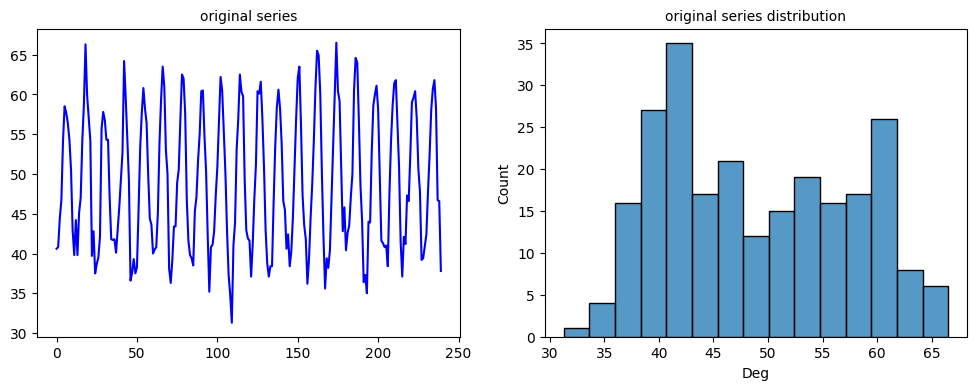

In [10]:
dftest_original_pvalue = adfuller(series_original, autolag='AIC')[1]
print(f'Dickey-Fuller serias_original test p-value: {dftest_original_pvalue}', '\n')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(series_original, color='blue')
ax1.set_title('original series', fontsize=10)
sns.histplot(x=series_original, bins=15, ax=ax2)
ax2.set_title('original series distribution', fontsize=10)
plt.show()

## 3. Data preparation.

### 3.1 Data transformation

In [11]:
series_transformed = np.log(series_original) # variance reducing
series_transformed = np.diff(series_transformed) # removing a trend
series_transformed = np.diff(np.array([series_transformed[:-12], series_transformed[12:]]), axis=0)[0] # removing a seasonality
series_transformed = pd.Series(series_transformed)

### 3.2 Transformed data analysis

series_transformed Dickey-Fuller test p-value: 2.361163522472863e-12, shapiro p-value: 0.2528594732284546 



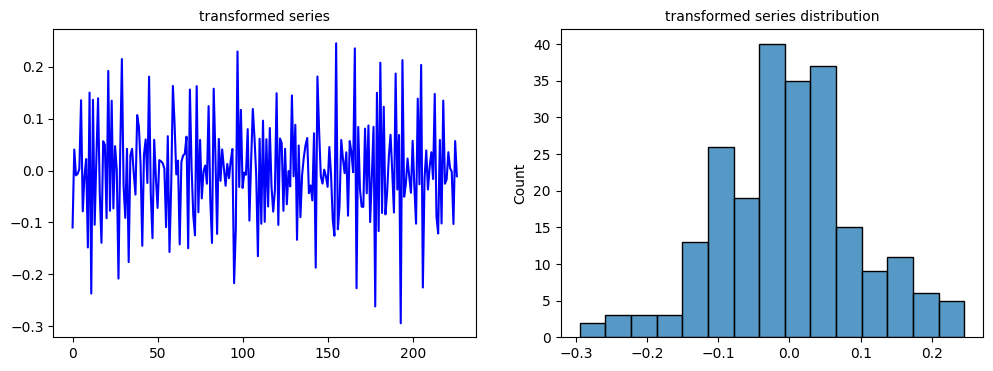

In [12]:
dftest_transformed_pvalue = adfuller(series_transformed, autolag='AIC')[1]
_, p_value = shapiro(series_transformed)
print(f'series_transformed Dickey-Fuller test p-value: {dftest_transformed_pvalue}, shapiro p-value: {p_value}', '\n')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(series_transformed, color='blue')
ax1.set_title('transformed series', fontsize=10)
sns.histplot(x=series_transformed, bins=15, ax=ax2)
ax2.set_title('transformed series distribution', fontsize=10)
plt.show()


## 4. Modeling

### 4.1 Moving average

Идеальное значение MSE = 0 достигаеться при window=1. С учетом того, что при увеличении окна ряд будет сглаживаться и, соответственно расти MSE можно произвольно выбрать размер окна, например, 4 для сравнения в weighted moving average экспотенциальных весов и весов ряда Фибоначчи.

In [159]:
window = 4
original = []
transformed = []

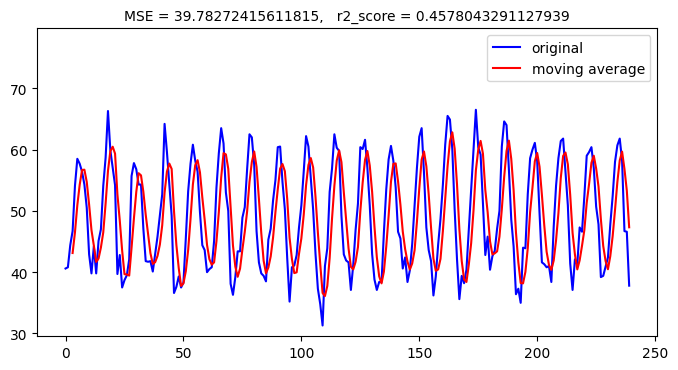

In [160]:
mao = moving_average(series_original, window)
err, r2score = mse_score(series_original[window-1:], mao[window-1:])
original.append(['ma, window=4', err, r2score])
fig = plt.figure(figsize=(8, 4))
plot_series([series_original, mao], ['blue', 'red'], ['original', 'moving average'])
plt.title(f'MSE = {err},   r2_score = {r2score}', fontsize=10)
plt.show()

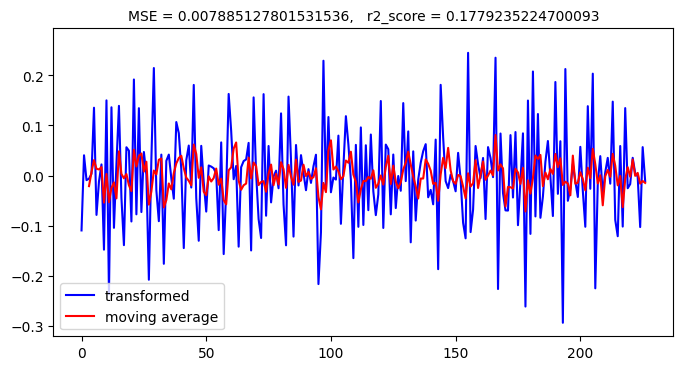

In [161]:
mat = moving_average(series_transformed, window)
err, r2score = mse_score(series_transformed[window-1:], mat[window-1:])
transformed.append(['ma, window=4', err, r2score])
fig = plt.figure(figsize=(8, 4))
plot_series([series_transformed, mat], ['blue', 'red'], ['transformed', 'moving average'])
plt.title(f'MSE = {err},   r2_score = {r2score}', fontsize=10)
plt.show()

### 3.2 Weighted moving average

In [162]:
fib_weights = [fib(i) for i in range(1, window+1)]
pow_weights = [2 ** i for i in range(window)]

In [163]:
wma_fib_or = weighted_moving_average(series_original, window, fib_weights)
wma_pow_or = weighted_moving_average(series_original, window, pow_weights)

err_fib, r2score_fib = mse_score(series_original[window-1:], wma_fib_or[window-1:])
err_pow, r2score_pow = mse_score(series_original[window-1:], wma_pow_or[window-1:])

original.append(['wma, window=4, weights=fib', err_fib, r2score_fib])
original.append(['wma, window=4, weights=pow', err_pow, r2score_pow])

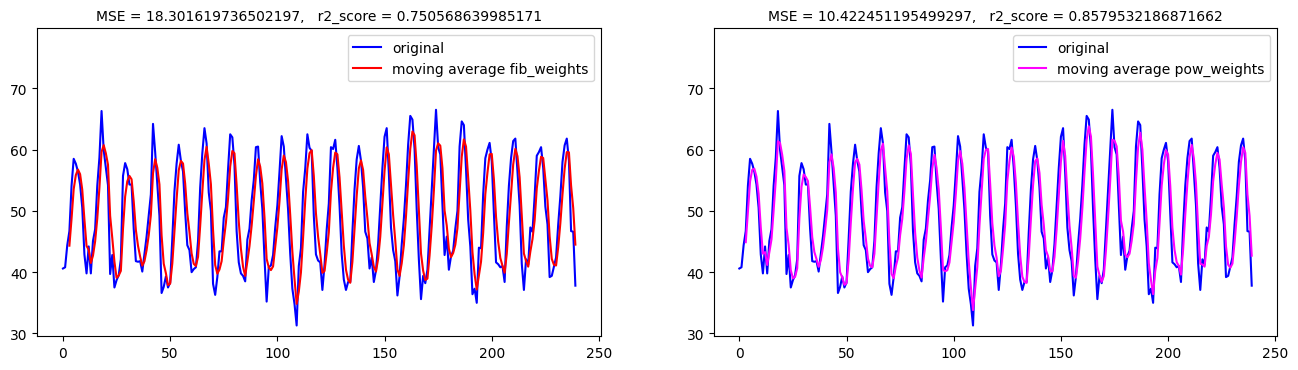

In [164]:
fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plot_series([series_original, wma_fib_or], ['blue', 'red'], ['original', 'moving average fib_weights'])
plt.title(f'MSE = {err_fib},   r2_score = {r2score_fib}', fontsize=10)
plt.subplot(1, 2, 2)
plot_series([series_original, wma_pow_or], ['blue', 'magenta'], ['original', 'moving average pow_weights'])
plt.title(f'MSE = {err_pow},   r2_score = {r2score_pow}', fontsize=10)
plt.show()

In [165]:
wma_fib_tr = weighted_moving_average(series_transformed, window, fib_weights)
wma_pow_tr = weighted_moving_average(series_transformed, window, pow_weights)

err_fib, r2score_fib = mse_score(series_transformed[window-1:], wma_fib_tr[window-1:])
err_pow, r2score_pow = mse_score(series_transformed[window-1:], wma_pow_tr[window-1:])

transformed.append(['wma, window=4, weights=fib', err_fib, r2score_fib])
transformed.append(['wma, window=4, weights=pow', err_pow, r2score_pow])

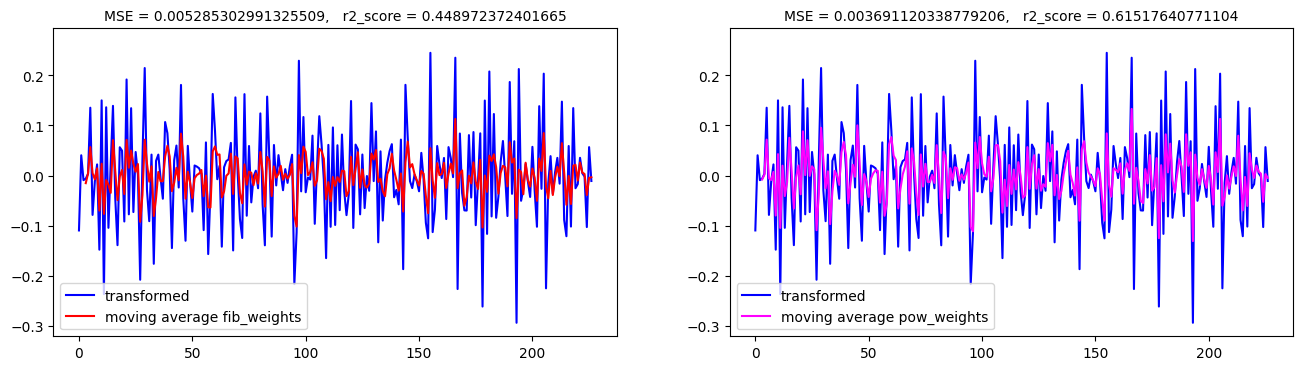

In [166]:
fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plot_series([series_transformed, wma_fib_tr], ['blue', 'red'], ['transformed', 'moving average fib_weights'])
plt.title(f'MSE = {err_fib},   r2_score = {r2score_fib}', fontsize=10)
plt.subplot(1, 2, 2)
plot_series([series_transformed, wma_pow_tr], ['blue', 'magenta'], ['transformed', 'moving average pow_weights'])
plt.title(f'MSE = {err_pow},   r2_score = {r2score_pow}', fontsize=10)
plt.show()

В обоих случаях экспотенциальные веса дают лучшее значение MSE, чем веса из ряда Фибоначчи.

### 3.3 Exponential smoothing

Из формулы очевидно, что наилучшее приближение будет происходить при $\alpha$ = 1. При $\alpha$ = 0 сглаживание приведет к константе series[0]

In [167]:
def exponential_moving_average(series, alpha):
  '''returns exponential moving average'''
  result = [series[0]]
  for n in range(1, len(series)):
      result.append(alpha * series[n] + (1 - alpha) * result[n-1])
  return pd.Series(result)


def emse(alpha, series):
  predictions = exponential_moving_average(series, alpha)
  error = mean_squared_error(series, predictions)
  return error

In [168]:
opt_original = minimize(emse, x0=[0], args=(series_original), method="L-BFGS-B", bounds = ((0, 1),)).x
opt_transformed = minimize(emse, x0=[0], args=(series_transformed), method="L-BFGS-B", bounds = ((0, 1),)).x
print(opt_original, opt_transformed)

[1.] [1.]


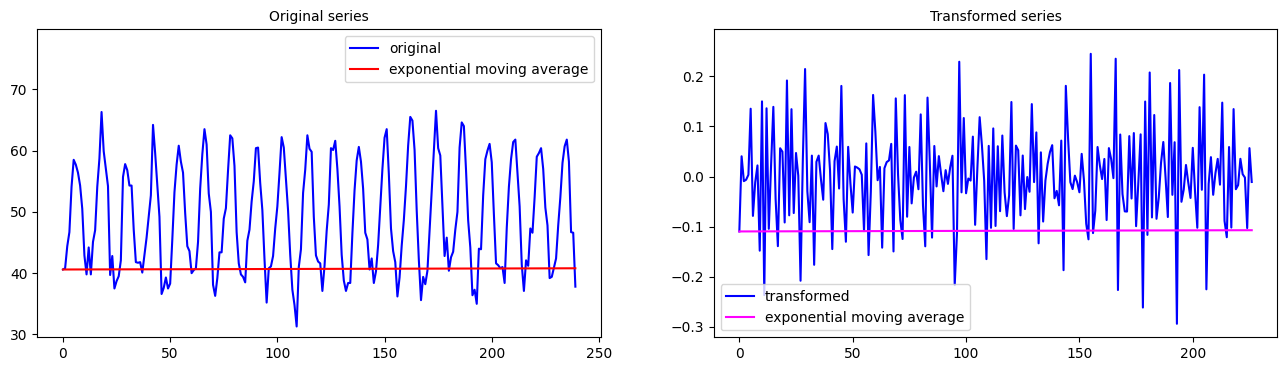

In [169]:
alpha = 0.0001
ema_original = exponential_moving_average(series_original, alpha)
ema_transformed = exponential_moving_average(series_transformed, alpha)

fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plot_series([series_original, ema_original], ['blue', 'red'], ['original', 'exponential moving average'])
plt.title('Original series', fontsize=10)
plt.subplot(1, 2, 2)
plot_series([series_transformed, ema_transformed], ['blue', 'magenta'], ['transformed', 'exponential moving average'])
plt.title('Transformed series', fontsize=10)
plt.show()

Подходит для сглаживания ряда, где или мало данных, или имеются пропуски в данных.

In [170]:
alpha = 0.9
ema_original = exponential_moving_average(series_original, alpha)
ema_transformed = exponential_moving_average(series_transformed, alpha)

err_or, r2score_or = mse_score(series_original, ema_original)
err_tr, r2score_tr = mse_score(series_transformed, ema_transformed)

original.append(['ema, alpha=0.9', err_or, r2score_or])
transformed.append(['ema, alpha=0.9', err_tr, r2score_tr])

### 3.4 Double exponential smoothing

In [171]:
def double_ema(series, alpha, beta):
  '''returns double exponential moving average'''
  result = [series[0]]
  level, trend = series[0], series[1] - series[0]
  for n in range(1, len(series)):
      value = series[n]
      last_level, level = level, alpha*value + (1-alpha)*(level+trend)
      trend = beta*(level-last_level) + (1-beta)*trend
      result.append(level+trend)
  return pd.Series(result)


def demse(X, series):
  alpha, beta = X
  predictions = double_ema(series, alpha, beta)
  error = mean_squared_error(series, predictions)
  return error

In [172]:
opt_original = minimize(demse, x0=[0, 0], args=(series_original), method="L-BFGS-B", bounds = ((0, 1), (0, 1))).x
opt_transformed = minimize(demse, x0=[0, 0], args=(series_transformed), method="L-BFGS-B", bounds = ((0, 1), (0, 1))).x
print(opt_original, opt_transformed)

[0.99651417 0.00770499] [0.91123612 0.20850888]


In [173]:
preds_original = double_ema(series_original, opt_original[0], opt_original[1])
preds_transformed = double_ema(series_transformed, opt_transformed[0], opt_transformed[1])

err_or, r2score_or = mse_score(series_original, preds_original)
err_tr, r2score_tr = mse_score(series_transformed, preds_transformed)

original.append(['dema', err_or, r2score_or])
transformed.append(['dema', err_tr, r2score_tr])

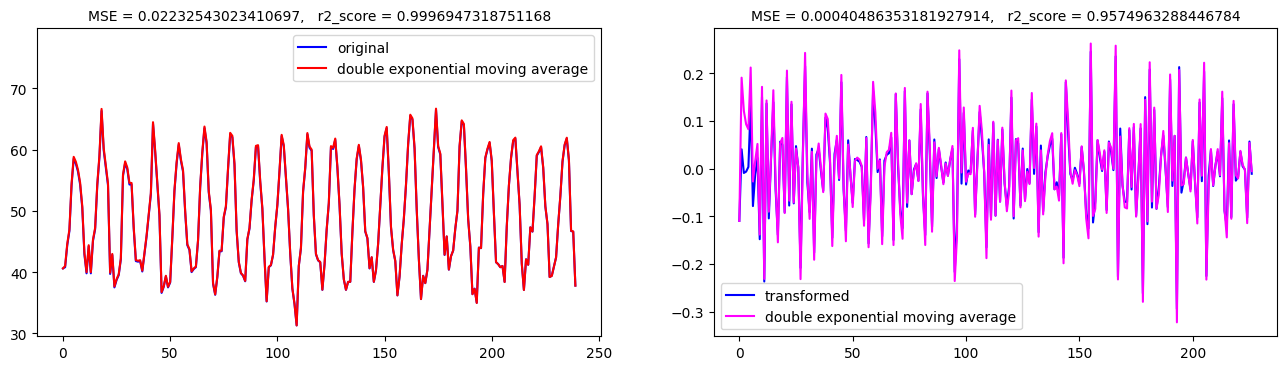

In [174]:
fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plot_series([series_original, preds_original], ['blue', 'red'], ['original', 'double exponential moving average'])
plt.title(f'MSE = {err_or},   r2_score = {r2score_or}', fontsize=10)
plt.subplot(1, 2, 2)
plot_series([series_transformed, preds_transformed], ['blue', 'magenta'], ['transformed', 'double exponential moving average'])
plt.title(f'MSE = {err_tr},   r2_score = {r2score_tr}', fontsize=10)
plt.show()

Модель опять выбирает $\alpha$ практически равное 1, при отсутствии заметного тренда получается малое значение MSE.

## 3.5 Triple exponential smoothing

In [175]:
def initial_trend(series, slen):
  return sum([float(series_original[i + slen] - series_original[i]) / slen for i in range(slen)]) / slen


def initial_seasonal_components(series, slen):
  seasonals = {}
  season_averages = []
  n_seasons = int(len(series)/slen)
  # compute season averages
  for j in range(n_seasons):
      season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
  # compute initial values
  for i in range(slen):
      sum_of_vals_over_avg = 0.0
      for j in range(n_seasons):
          sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
      seasonals[i] = sum_of_vals_over_avg/n_seasons
  return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
  result = []
  seasonals = initial_seasonal_components(series, slen)
  for i in range(len(series)+n_preds):
      if i == 0: # initial values
          smooth = series[0]
          trend = initial_trend(series, slen)
          result.append(series[0])
          continue
      if i >= len(series): # we are forecasting
          m = i - len(series) + 1
          result.append((smooth + m*trend) + seasonals[i%slen])
      else:
          val = series[i]
          last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
          trend = beta * (smooth-last_smooth) + (1-beta)*trend
          seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
          result.append(smooth+trend+seasonals[i%slen])
  return result


def temse(X, series, slen, n_preds):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds)
    predictions = result[-n_preds:]
    error = mean_squared_error(series[-n_preds:], predictions)
    return error

In [176]:
slen = 12 # series - среднемесячная температура
n_preds = 100

opt_original = minimize(temse, x0=[0, 0, 0], args=(series_original[:-n_preds], slen, n_preds), method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1))).x
opt_transformed = minimize(temse, x0=[0, 0, 0], args=(series_transformed[:-n_preds], slen, n_preds), method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1))).x
print(opt_original, opt_transformed)

[0.96977776 0.01414503 1.        ] [0.97306186 0.03059814 0.9912229 ]


In [177]:
preds_original = triple_exponential_smoothing(series_original[:-n_preds], slen, opt_original[0], opt_original[1], opt_original[2], n_preds)
preds_transformed = triple_exponential_smoothing(series_transformed[:-n_preds], slen, opt_original[0], opt_original[1], opt_original[2], n_preds)

err_or, r2score_or = mse_score(series_original, preds_original)
err_tr, r2score_tr = mse_score(series_transformed, preds_transformed)

original.append(['tema', err_or, r2score_or])
transformed.append(['tema', err_tr, r2score_tr])

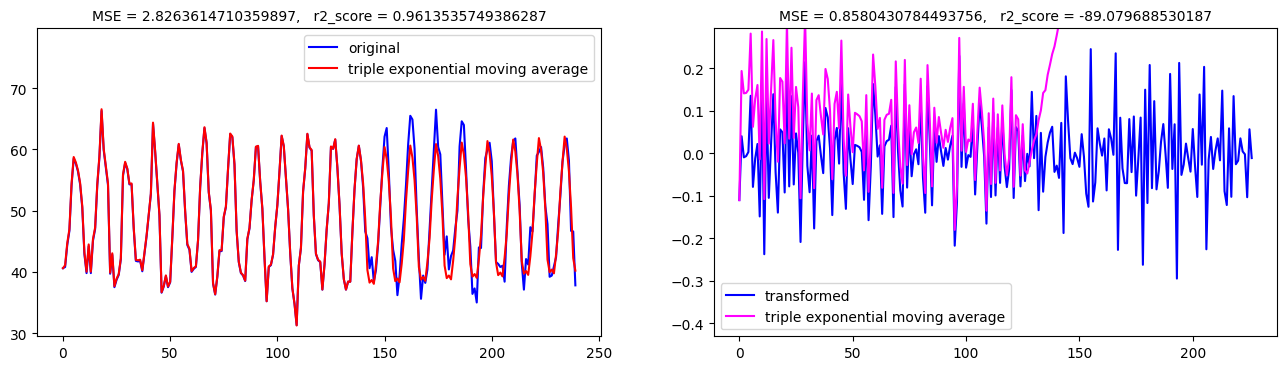

In [178]:
fig = plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plot_series([series_original, preds_original], ['blue', 'red'], ['original', 'triple exponential moving average'])
plt.title(f'MSE = {err_or},   r2_score = {r2score_or}', fontsize=10)
plt.subplot(1, 2, 2)
plot_series([series_transformed, preds_transformed], ['blue', 'magenta'], ['transformed', 'triple exponential moving average'])
plt.title(f'MSE = {err_tr},   r2_score = {r2score_tr}', fontsize=10)
plt.show()

Метод Хольта-Винтерса хорошо предсказывает значения ряда с наличием сезонности и плохо работает с белым шумом, которым практически является series_transformed.

### 3.6 Cross-validation

In [179]:
def mse_cross_val(X, series, slen):
  alpha, beta, gamma = X
  tscv = TimeSeriesSplit(n_splits=3) 
  errors = []
  
  for train_split, test_split in tscv.split(series):
    train_split_ts = series.iloc[train_split]
    test_split_ts = series.iloc[test_split]
    result = triple_exponential_smoothing(train_split_ts, slen, alpha, beta, gamma, len(test_split))
    predictions = result[-len(test_split_ts):]
    error = mean_squared_error(test_split_ts, predictions)
    errors.append(error)
  return np.mean(np.array(errors))

In [180]:
opt = minimize(mse_cross_val, x0=[0,0,0], args=(series_original, slen), method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1))).x
print(opt)

[1.         0.01315924 1.        ]


In [181]:
preds = triple_exponential_smoothing(series_original[:-n_preds], slen, opt_original[0], opt_original[1], opt_original[2], n_preds)
err, r2score = mse_score(series_original, preds_original)
original.append(['cross-val', err_or, r2score_or])

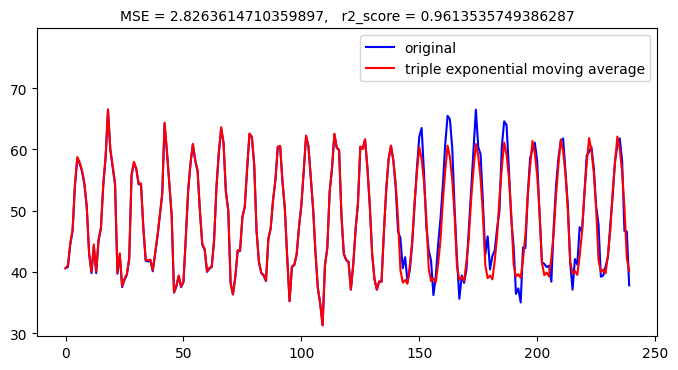

In [182]:
fig = plt.figure(figsize=(8, 4))
plot_series([series_original, preds], ['blue', 'red'], ['original', 'triple exponential moving average'])
plt.title(f'MSE = {err_or},   r2_score = {r2score_or}', fontsize=10)
plt.show()

Получен практически такой же результат, как и в предыдущем случае.

In [183]:
cols = ['model', 'mse', 'r2_score']
original = pd.DataFrame(original, columns=cols)
transformed = pd.DataFrame(transformed, columns=cols)

In [184]:
original

,model,mse,r2_score
0,"ma, window=4",39.782724,0.457804
1,"wma, window=4, weights=fib",18.301620,0.750569
2,"wma, window=4, weights=pow",10.422451,0.857953
3,"ema, alpha=0.9",0.302111,0.995869
4,dema,0.022325,0.999695
5,tema,2.826361,0.961354
6,cross-val,2.826361,0.961354


In [185]:
transformed

,model,mse,r2_score
0,"ma, window=4",0.007885,0.177924
1,"wma, window=4, weights=fib",0.005285,0.448972
2,"wma, window=4, weights=pow",0.003691,0.615176
3,"ema, alpha=0.9",0.000244,0.974385
4,dema,0.000405,0.957496
5,tema,0.858043,-89.079689
